라이브러리

In [1]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 모델명(= 파일명) 설정
model_name = 'doRegressor_tank1redofood'

In [2]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

# 모델 평가 함수
def grapeNEva(model, X_test_shape, y_test):
    X_pred = model.predict(X_test_shape)
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.reshape((-1))
    print(len(X_pred))

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='actual')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction')  # x축에 년월일, y축에 시분
    plt.xlabel('날짜')
    plt.ylabel('DO')
    plt.title('시계열')
    plt.legend(['y_test','X_pred'])
    plt.show()
    
    # 평가 생성
    #result = model.evaluate(X_test_shape, y_test)
    #print("MSE // MAE // R-squared ", result)
    

데이터셋 설정

In [3]:
#자포니카 훈련 데이터
japonica_training_food_supply_tb = pd.read_csv("eeldata/data/Training/Origin/Management/Japonica/food_supply_tb.csv")
japonica_training_sensor_val_tb = pd.read_csv("eeldata/data/Training/Origin/Sensor/Japonica/sensor_val_tb.csv")

#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("eeldata/data/Validation/Origin/Management/Japonica/food_supply_tb.csv")
japonica_validation_sensor_val_tb = pd.read_csv("eeldata/data/Validation/Origin/Sensor/Japonica/sensor_val_tb.csv")

#자포니카 훈련 데이터 시계열 변환
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].apply(str)
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_training_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_training_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].apply(str)
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

#자포니카 검증 데이터 시계열 변환
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_training = pd.merge(left = japonica_training_sensor_val_tb, right = japonica_training_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

#자포니카 훈련 및 검증 데이터 시계열 변환
japonica_training['mea_dt'] = pd.to_datetime(japonica_training['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

In [4]:
# 자포니카 검증 데이터의 한 개 탱크
tank = 1
japonica_training_tank = japonica_training[japonica_training['tank_id']==tank]
japonica_validation_tank = japonica_validation[japonica_validation['tank_id']==tank]

In [5]:
# 사용할 features 선택
feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_training_features = japonica_training_tank[feature_origin]
japonica_validation_features = japonica_validation_tank[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_training_features = japonica_training_features.fillna(0)
japonica_validation_features = japonica_validation_features.fillna(0)

In [6]:
# 시계열 데이터의 개수 확인
training_counts = japonica_training_features.groupby(japonica_training_features['mea_dt'].dt.date).size()
#validation_counts = japonica_validation_features.groupby(japonica_validation_features.index.mea_dt).size()

# 개수가 1440이 아닌 시계열 삭제
to_delete = training_counts[training_counts != 1440].index
japonica_training_data = japonica_training_features[~japonica_training_features['mea_dt'].dt.date.isin(to_delete)]

#to_delete = validation_counts[validation_counts != 1440].index
#japonica_validation_data = japonica_validation_features[~japonica_validation_features.index.floor('D').isin(to_delete)]

In [7]:
japonica_validation_data = japonica_validation_features

In [8]:
# 날짜 데이터를 인덱스로 전환
japonica_training_data.set_index('mea_dt', inplace=True)
japonica_validation_data.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_training_data = japonica_training_data.sort_index()
japonica_validation_data = japonica_validation_data.sort_index()

# 8월 1달간 데이터만 추출
japonica_training_data = japonica_training_data.loc['2021-07-21 00:00':'2021-09-10 23:59']
japonica_validation_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-10 23:59']

In [9]:
japonica_training_features_X = japonica_training_data[['do_mg','feed_quantity']]
japonica_training_features_y = japonica_training_data[['do_mg']]

japonica_validation_features_X = japonica_validation_data[['do_mg', 'feed_quantity']]
japonica_validation_features_y = japonica_validation_data[['do_mg']]

In [10]:
japonica_training_features_X_chunks = []
japonica_training_features_y_chunks = []

for i in range(0, len(japonica_training_features_X) - 179):
    japonica_training_features_X_chunks.append(np.array(japonica_training_features_X.iloc[i:i+180].values, dtype=np.float64))
japonica_training_features_X_chunks = np.array(japonica_training_features_X_chunks, dtype=np.float64)

for i in range(0, len(japonica_training_features_y) - 179):
    japonica_training_features_y_chunks.append(np.array(japonica_training_features_y.iloc[i:i+180].values, dtype=np.float64))
japonica_training_features_y_chunks = np.array(japonica_training_features_y_chunks, dtype=np.float64)


In [11]:
japonica_validation_features_X_chunks = []
japonica_validation_features_y_chunks = []


for i in range(0, len(japonica_validation_features_X) - 179):
    japonica_validation_features_X_chunks.append(np.array(japonica_validation_features_X.iloc[i:i+180].values, dtype=np.float64))
japonica_validation_features_X_chunks = np.array(japonica_validation_features_X_chunks, dtype=np.float64)

for i in range(0, len(japonica_validation_features_y) - 179):
    japonica_validation_features_y_chunks.append(np.array(japonica_validation_features_y.iloc[i:i+180].values, dtype=np.float64))
japonica_validation_features_y_chunks = np.array(japonica_validation_features_y_chunks, dtype=np.float64)

In [12]:
# shape확인
nCar = japonica_training_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64621 nVar: 2
nCar: 64621 nVar: 180
nCar: 74120 nVar: 2
nCar: 74120 nVar: 180


In [13]:
japonica_training_features_X_chunks_crop = japonica_training_features_X_chunks[:-180]
japonica_training_features_y_chunks_crop = japonica_training_features_y_chunks[180:]

japonica_validation_features_X_chunks_crop = japonica_validation_features_X_chunks[:-180]
japonica_validation_features_y_chunks_crop = japonica_validation_features_y_chunks[180:]

In [14]:
nCar = japonica_training_features_X_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks_crop.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks_crop.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_validation_features_y_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64441 nVar: 2
nCar: 64441 nVar: 180
nCar: 73940 nVar: 2
nCar: 73940 nVar: 180


LSTM 모델 학습 (학습시에만 사용, 그외에는 불필요)

In [16]:
# LSTM 모델 생성
model = Sequential()
# 결과값이 128개 -> 64개 -> 32개 -> 1개(회귀)
# input_shape=(timesteps, input_dim)
# timesteps : 시계열 데이터의 시간 스텝 수.
#       예를 들어, 1분 단위로 측정한 센서 데이터가 있다면 timesteps는 60.
# input_dim : 특성(feature)의 수.
model.add(LSTM(128, input_shape=(180, 2), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(180, activation='linear'))
 
model.summary()

# mae와 r_squared 평가함수 추가.
model.compile(optimizer='adam', loss='mse', metrics=['mae', r_squared])


checkpoint = ModelCheckpoint(model_name + '_best.h5', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# ModelCheckpoint : 검증 손실이 낮아진 경우에 최적의 모델을 저장
# EarlyStopping : 검증 손실이 일정 기간동안 향상되지 않으면 학습을 조기 종료
# ReduceLROnPlateau : 검증 손실이 개선되지 않으면 학습률을 조정하는 등의 동작 수행.


hist = model.fit(japonica_training_features_X_chunks_crop, japonica_training_features_y_chunks_crop, epochs = 200, batch_size = 32, validation_data=(japonica_validation_features_X_chunks_crop, japonica_validation_features_y_chunks_crop), callbacks=[checkpoint, early_stop, reduce_lr])
model.save(model_name+'.h5')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 180, 128)          67072     
_________________________________________________________________
lstm_4 (LSTM)                (None, 180, 64)           49408     
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 180)               5940      
Total params: 134,836
Trainable params: 134,836
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200


2023-07-08 05:07:05.773418: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200
2023-07-08 05:07:07.173486: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2014/2014 [==============================] - 112s 52ms/step - loss: 5.0426 - mae: 1.4361 - r_squared: -2.6893 - val_loss: 1.5406 - val_mae: 0.9199 - val_r_squared: -37.7875
Epoch 2/200
2014/2014 [==============================] - 104s 52ms/step - loss: 1.4700 - mae: 0.9111 - r_squared: -0.0309 - val_loss: 1.5405 - val_mae: 0.9202 - val_r_squared: -37.7681
Epoch 3/200
2014/2014 [==============================] - 104s 52ms/step - loss: 1.0845 - mae: 0.7324 - r_squared: 0.2357 - val_loss: 0.3427 - val_mae: 0.3711 - val_r_squared: -1.9630
Epoch 4/200
2014/2014 [==============================] - 103s 51ms/step - loss: 0.3495 - mae: 0.3776 - r_squared: 0.7461 - val_loss: 0.3161 - val_mae: 0.3636 - val_r_squared: -2.0732
Epoch 5/200
2014/2014 [==============================] - 103s 51ms/step - loss: 0.3388 - mae: 0.3706 - r_squared: 0.7531 - val_loss: 0.3496 - val_mae: 0.4133 - val_r_squared: -3.3744
Epoch 6/200
2014/2014 [==============================] - 103s 51ms/step - loss: 0.3277 - mae:

2014/2014 [==============================] - 103s 51ms/step - loss: 0.2235 - mae: 0.3070 - r_squared: 0.8360 - val_loss: 0.2116 - val_mae: 0.3090 - val_r_squared: -1.9170

Epoch 00045: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 46/200
2014/2014 [==============================] - 105s 52ms/step - loss: 0.1849 - mae: 0.2860 - r_squared: 0.8633 - val_loss: 0.1816 - val_mae: 0.2916 - val_r_squared: -1.6149
Epoch 47/200
2014/2014 [==============================] - 104s 52ms/step - loss: 0.1733 - mae: 0.2803 - r_squared: 0.8702 - val_loss: 0.1985 - val_mae: 0.2917 - val_r_squared: -1.4783
Epoch 00047: early stopping


모델 평가

모델 평가

In [11]:
# r_squared가 따로 만들어서 추가해준 함수기 때문에 불러올 때도 추가해서 불러야한다.
model = load_model(model_name+'.h5', custom_objects={'r_squared': r_squared})

[[ 0.04123846 -0.08717101  0.03503811 ...  0.03751392  0.04791444
   0.3678781 ]
 [ 0.16532552  0.0792144   0.02432945 ...  0.05856925  0.00090234
  -0.03394513]
 [-0.00622267 -0.03351446  0.06223287 ...  0.01745683 -0.18967046
   0.20858984]
 ...
 [ 0.08247125 -0.08036777  0.06337326 ... -0.02996756 -0.13013864
   0.15816759]
 [-0.04194462 -0.05256636  0.00120261 ... -0.04911606 -0.07538651
  -0.04824786]
 [-0.07896454 -0.13964073 -0.07037744 ... -0.00857883  0.09665971
   0.07223787]]


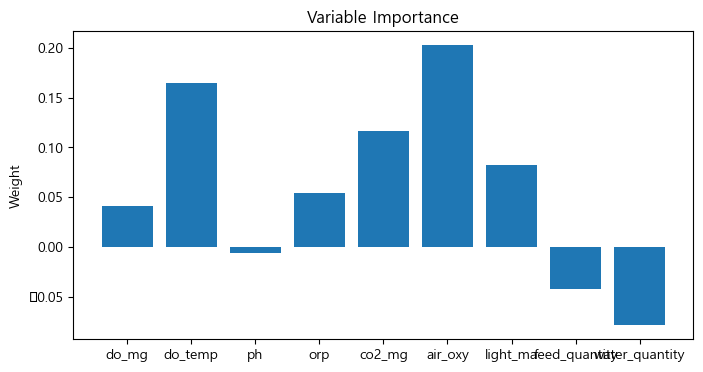

In [15]:
# 가중치를 통해 변수 중요도 획득
weights = model.layers[0].get_weights()[0]
print(weights)


# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(9), weights[:, 0])
ax.set_xticks(range(9))
ax.set_xticklabels(['do_mg', 'do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity'])
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

In [16]:
X_pred = model.predict(japonica_training_features_X_reshape)
X_pred = np.array(X_pred).flatten()

X_pred = pd.DataFrame(X_pred)

start = pd.Timestamp(japonica_training_features_X.index[0]) + pd.Timedelta(hours=3)

# 시계열 인덱스 생성
index = pd.date_range(start, periods=len(X_pred), freq='1min')

# 데이터프레임의 인덱스를 시계열 인덱스로 변경
X_pred.index = index

X_pred

36/36 [==============================] - 3s 64ms/step


,0
2021-07-16 03:00:00,8.372029
2021-07-16 03:01:00,8.359147
2021-07-16 03:02:00,8.348216
2021-07-16 03:03:00,8.340155
2021-07-16 03:04:00,8.324379
...,...
2021-12-06 02:55:00,11.262277
2021-12-06 02:56:00,11.266744
2021-12-06 02:57:00,11.260895
2021-12-06 02:58:00,11.263826


In [17]:
japonica_training_features_y = japonica_training_features_y.reset_index()
japonica_training_features_y['mea_dt'] = pd.to_datetime(japonica_training_features_y['mea_dt'], format='mixed', errors='raise')
japonica_training_features_y.set_index('mea_dt', inplace=True)
japonica_training_features_y

,do_mg
mea_dt,
2021-07-16 00:00:00,8.3
2021-07-16 00:01:00,8.4
2021-07-16 00:02:00,8.4
2021-07-16 00:03:00,8.4
2021-07-16 00:04:00,8.4
...,...
2022-01-05 23:55:00,12.0
2022-01-05 23:56:00,12.0
2022-01-05 23:57:00,12.0


In [ ]:
japonica_training_features_y.index

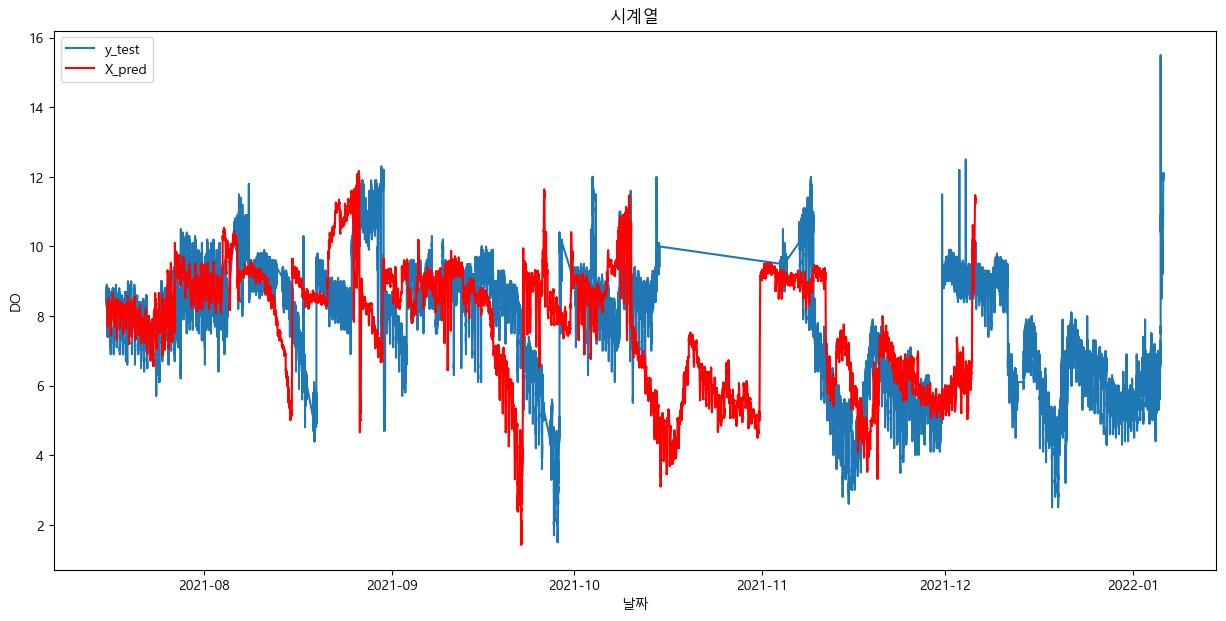

In [18]:
# 그래프 생성
plt.figure(figsize=(15, 7))
plt.plot(japonica_training_features_y.index, japonica_training_features_y, label='actual')  # x축에 년월일, y축에 값
plt.plot(X_pred.index, X_pred, color='red', label='prediction')  # x축에 년월일, y축에 시분
plt.xlabel('날짜')
plt.ylabel('DO')
plt.title('시계열')
plt.legend(['y_test','X_pred'])
plt.show()

In [26]:
# 하루 동안의 데이터 추출
one_day_data = japonica_training_data.loc['2021-08-01 00:00':'2021-08-31 23:59']
oneday_X_test = one_day_data[['do_mg', 'do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
one_day_data = japonica_training_data.loc['2021-08-01 03:00':'2021-09-01 02:59']
oneday_y_test = one_day_data[['do_mg']]

oneday_X_test_reshape = np.asarray(oneday_X_test, dtype=np.float64)
oneday_X_test_reshape = oneday_X_test_reshape.reshape((-1, 180, 9))

# shape확인
nCar = oneday_X_test_reshape.shape[0] # 데이터 개수
nVar = oneday_X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test.shape[0] # 데이터 개수
nVar = oneday_y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 224 nVar: 9
nCar: 40320 nVar: 1


7/7 [==============================] - 1s 72ms/step
40320


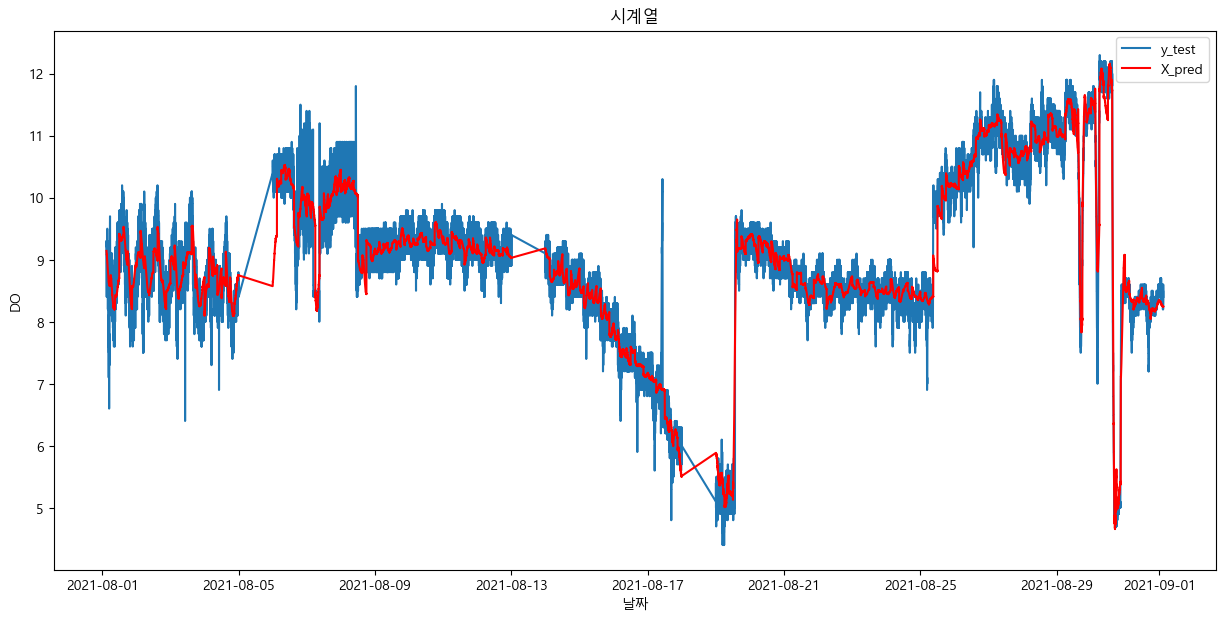

In [27]:
grapeNEva(model, oneday_X_test_reshape, oneday_y_test)

In [ ]:
# 자포니카 검증 데이터의 한 개 탱크
tank = 1
japonica_validation_features_tank = japonica_validation_features[japonica_validation_features['tank_id']==tank]

# 하루 동안의 데이터 추출
one_day_data = japonica_validation_features_tank.loc['2021-07-16 00:00:00':'2021-07-16 23:59:59']
oneday_X_test = one_day_data[feature_Learning]
oneday_y_test = one_day_data[['do_mg']]

oneday_X_test_reshape = np.asarray(oneday_X_test, dtype=np.float64)
oneday_X_test_reshape = oneday_X_test_reshape.reshape((-1, 1, feature_number))

# shape확인
nCar = oneday_X_test_reshape.shape[0] # 데이터 개수
nVar = oneday_X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test.shape[0] # 데이터 개수
nVar = oneday_y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

In [ ]:
grapeNEva(model, oneday_X_test_reshape, oneday_y_test)

In [ ]:
# 자포니카 검증 데이터의 한 개 탱크
tank = 1
japonica_validation_features_tank = japonica_validation_features[japonica_validation_features['tank_id']==tank]

# 하루 동안의 데이터 추출
one_day_data = japonica_validation_features_tank.loc['2021-08-28 00:00:00':'2021-08-28 23:59:59']
oneday_X_test = one_day_data[feature_Learning]
oneday_y_test = one_day_data[['do_mg']]

oneday_X_test_reshape = np.asarray(oneday_X_test, dtype=np.float64)
oneday_X_test_reshape = oneday_X_test_reshape.reshape((-1, 1, feature_number))

# shape확인
nCar = oneday_X_test_reshape.shape[0] # 데이터 개수
nVar = oneday_X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test.shape[0] # 데이터 개수
nVar = oneday_y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

In [ ]:
grapeNEva(model, oneday_X_test_reshape, oneday_y_test)